# 20240915
★ shot grid 수정해야함.  그냥 단순히 step pitch로 쪼개놓은것임.-> 개선필요

1. Shot Left부분 그리기. 
   wafer정센터(0,0)에서 step_pitch의 절반만큼 -방향으로 이동. 
   
2. map shift 고려. 
   map shift만큼을 더해준다.

3. +방향에서는 step pitch만큼 n개씩 더해준다. 
   -방향에서는 step pitch만큼 m개씩 빼준다. 

# 20240915(2)
함수로 변경해줌

# 20240916
1. WF7.5로 테스트 해보기. OCM이랑 비교용
2. 화살표 머리부분 크기 조정. headwidth=2, headlength=3
3. 양수die, 음수die 정보를 매뉴얼로 넣어줘야하는 문제있음 -> max die, min die 정보를 활용. 대신에 vline, hline으로 나눠줘야함.

4. die x,y가 음수인 경우에 for문이 돌지않음. -> min에는 abs처리함.
5. shot left만 그려주는거라서 shot right부분 짤리는 경우있음 -> max_die + 2 처리해줌.(넉넉하게)
6. Die 위치 플롯기능은 삭제함.  die좌표계와 wf좌표계랑 안맞음.. 
   -> def plot_overlay(x, y, dx, dy, v_lines, h_lines, die_x, die_y, wafer_radius=150000, title='Wafer Vector Map'): 에서 die_x, die_y 삭제함.

7. lot_id 개별로 표현

# 20240917
1. subplot으로 여러개 plot정리하기
2. 확대했을때 크기 키움.  fig, axes = plt.subplots(1, 5, figsize=(50, 10))
3. scale bar 추가
4. scale bar와 scale_factor간에 연동되게 변경
   import matplotlib.pyplot as plt
   import matplotlib.patches as patches
   from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
   import matplotlib.font_manager as fm

  # 스케일 바 추가
    fontprops = fm.FontProperties(size=10)
    scalebar = AnchoredSizeBar(ax.transData,
                               30000,  # 데이터 좌표에서의 스케일 바 길이 (기본 길이)
                               scale_bar_label,  # 스케일 바 레이블 (계산된 값 사용)
                               'lower center',  # 스케일 바 위치
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=500,  # 스케일 바 두께
                               fontproperties=fontprops)
    ax.add_artist(scalebar)
    
5. 배열 변경.  1*5 -> 2*3 
6. mrc_fit, X_reg_demrc 추가 
7. TROCS INPUT, residual_detrocs 추가


# 20240921
1. ideal trocs 추가 
2. subpolt 배열변경


# 20240922 
1. subplot 배열변경.   (mrc부터 remove, ... )

# 20240923
 GUI로 구현. 
 1. unique_id로 list
 2. unique_id 클릭하면 popup으로 subplot을 띄워줌. 

 


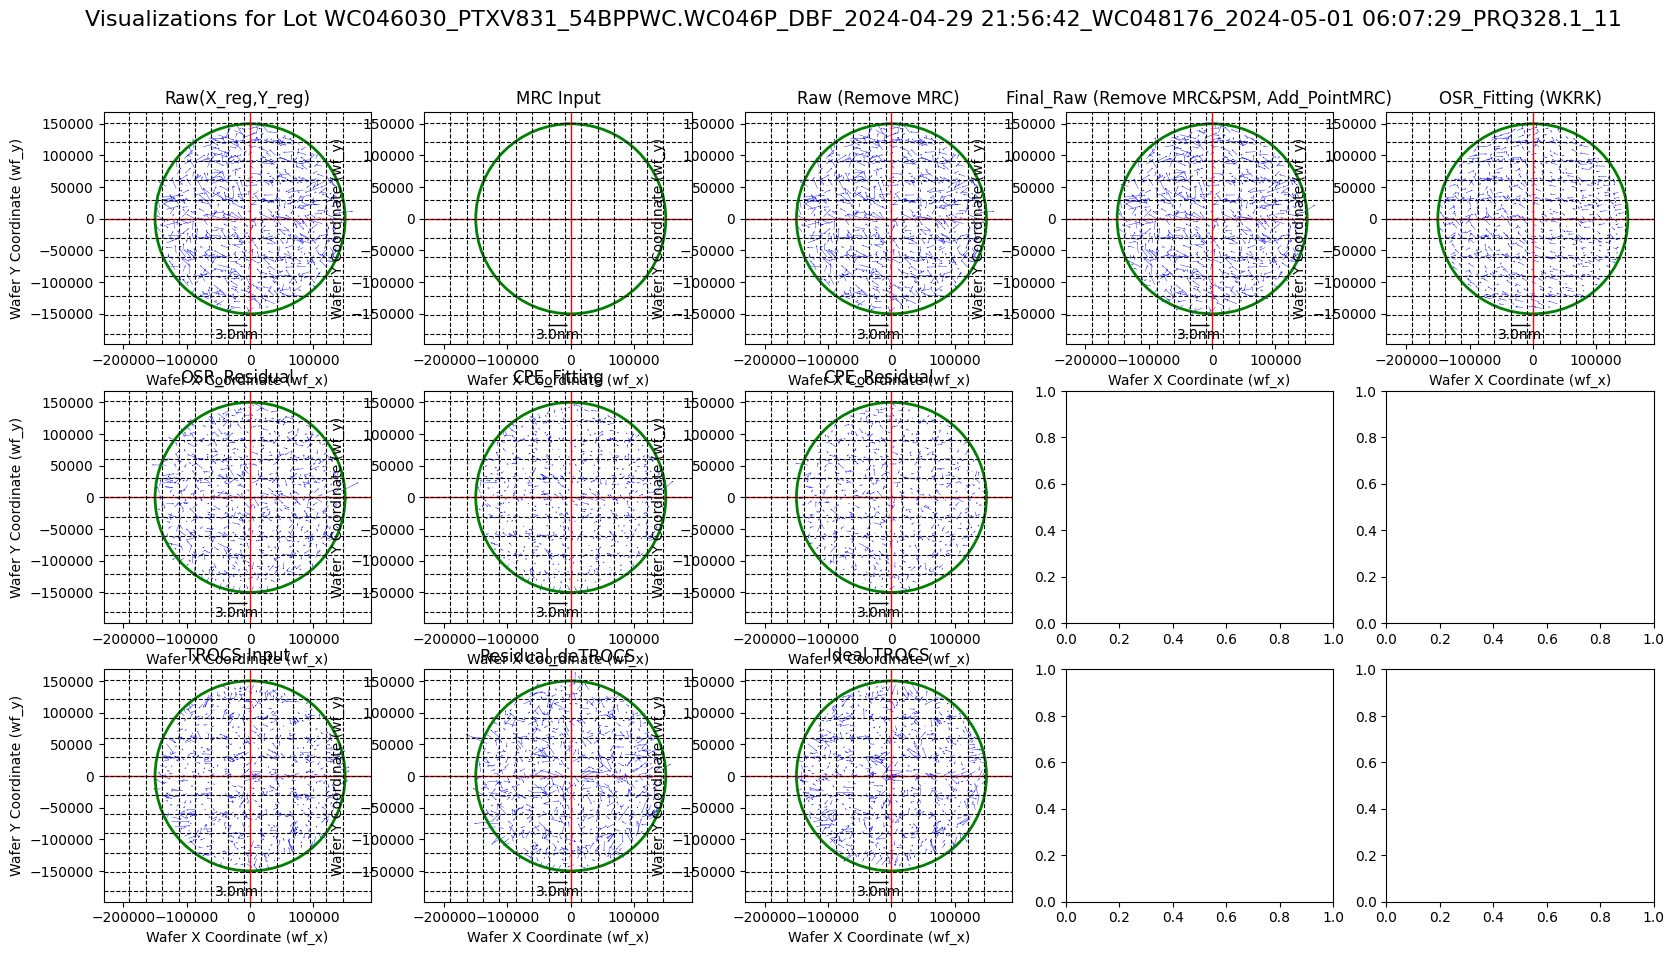

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk

# 세로선을 계산하는 함수
def calculate_vlines(center, pitch, max_die_x, min_die_x):
    lines = []
    current = center
    for _ in range(max_die_x + 2):
        lines.append(current)
        current += pitch
    current = center
    for _ in range(abs(min_die_x) + 1):
        current -= pitch
        lines.append(current)
    return lines

# 가로선을 계산하는 함수
def calculate_hlines(center, pitch, max_die_y, min_die_y):
    lines = []
    current = center
    for _ in range(max_die_y + 2):
        lines.append(current)
        current += pitch
    current = center
    for _ in range(abs(min_die_y) + 1):
        current -= pitch
        lines.append(current)
    return lines

# Overlay를 플롯하는 함수
def plot_overlay(ax, x, y, dx, dy, v_lines, h_lines, wafer_radius=150000, title='Wafer Vector Map', scale_factor=1e-7):
    ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=scale_factor, color='blue', label='Overlay Vectors',
              width=0.0015, headwidth=3, headlength=3)

    ax.axvline(0, color='red', linewidth=1.0, label='Central X')
    ax.axhline(0, color='red', linewidth=1.0, label='Central Y')

    for vline in v_lines:
        ax.axvline(vline, color='black', linestyle='--', linewidth=0.8)
    for hline in h_lines:
        ax.axhline(hline, color='black', linestyle='--', linewidth=0.8)

    wafer_circle = plt.Circle((0, 0), wafer_radius, color='green', fill=False, linestyle='-', linewidth=2, label='Wafer Boundary')
    ax.add_patch(wafer_circle)

    scale_bar_length = 30000 * scale_factor
    scale_bar_label = f'{scale_bar_length * 1e3:.1f}nm'

    fontprops = fm.FontProperties(size=10)
    scalebar = AnchoredSizeBar(ax.transData, 30000, scale_bar_label, 'lower center', pad=0.1, color='black',
                               frameon=False, size_vertical=500, fontproperties=fontprops)
    ax.add_artist(scalebar)

    ax.set_xlabel('Wafer X Coordinate (wf_x)')
    ax.set_ylabel('Wafer Y Coordinate (wf_y)')
    ax.set_title(title)
    ax.axis('equal')
    ax.grid(False)

# 플롯을 보여주는 함수
def show_plot(unique_id, df):
    df_lot = df[df['UNIQUE_ID'] == unique_id]
    
    wf_x = df_lot['wf_x']
    wf_y = df_lot['wf_y']
    X_reg = df_lot['X_reg']
    Y_reg = df_lot['Y_reg']
    mrc_fit_x = df_lot['mrc_fit_x']
    mrc_fit_y = df_lot['mrc_fit_y']
    X_reg_demrc = df_lot['X_reg_demrc']
    Y_reg_demrc = df_lot['Y_reg_demrc']
    raw_x = df_lot['raw_x']
    raw_y = df_lot['raw_y']
    pred_x = df_lot['pred_x']
    pred_y = df_lot['pred_y']
    residual_x = df_lot['residual_x']
    residual_y = df_lot['residual_y']
    cpe_pred_x = df_lot['cpe_pred_x']
    cpe_pred_y = df_lot['cpe_pred_y']
    cpe_resi_x = df_lot['cpe_resi_x']
    cpe_resi_y = df_lot['cpe_resi_y']
    trocs_fit_x = df_lot['trocs_fit_x']
    trocs_fit_y = df_lot['trocs_fit_y']
    residual_x_detrocs = df_lot['residual_x_detrocs']
    residual_y_detrocs = df_lot['residual_y_detrocs']
    ideal_trocs_x = df_lot['ideal_trocs_x']
    ideal_trocs_y = df_lot['ideal_trocs_y']

    step_pitch_x = df_lot['STEP_PITCH_X'].iloc[0]
    step_pitch_y = df_lot['STEP_PITCH_Y'].iloc[0]
    map_shift_x = df_lot['MAP_SHIFT_X'].iloc[0]
    map_shift_y = df_lot['MAP_SHIFT_Y'].iloc[0]
    start_left = -(step_pitch_x)/2 + map_shift_x
    start_bottom = -(step_pitch_y)/2 + map_shift_y
    max_die_x = max(df_lot['DieX'])
    min_die_x = min(df_lot['DieX'])
    max_die_y = max(df_lot['DieY'])
    min_die_y = min(df_lot['DieY'])

    vertical_lines = calculate_vlines(start_left, step_pitch_x, max_die_x, min_die_x)
    horizontal_lines = calculate_hlines(start_bottom, step_pitch_y, max_die_y, min_die_y)

    # Figure DPI and size adjustments
    fig, axes = plt.subplots(3, 5, figsize=(20, 12), dpi=100)
    fig.suptitle(f'Visualizations for Lot {unique_id}', fontsize=16)

    plot_overlay(axes[0,0], wf_x, wf_y, X_reg, Y_reg, vertical_lines, horizontal_lines, title='Raw(X_reg,Y_reg)')
    plot_overlay(axes[0,1], wf_x, wf_y, mrc_fit_x, mrc_fit_y, vertical_lines, horizontal_lines, title='MRC Input')
    plot_overlay(axes[0,2], wf_x, wf_y, X_reg_demrc, Y_reg_demrc, vertical_lines, horizontal_lines, title='Raw (Remove MRC)')
    plot_overlay(axes[0,3], wf_x, wf_y, raw_x, raw_y, vertical_lines, horizontal_lines, title='Final_Raw (Remove MRC&PSM, Add_PointMRC)')
    plot_overlay(axes[0,4], wf_x, wf_y, pred_x, pred_y, vertical_lines, horizontal_lines, title='OSR_Fitting (WKRK)')
    plot_overlay(axes[1,0], wf_x, wf_y, residual_x, residual_y, vertical_lines, horizontal_lines, title='OSR_Residual')
    plot_overlay(axes[1,1], wf_x, wf_y, cpe_pred_x, cpe_pred_y, vertical_lines, horizontal_lines, title='CPE_Fitting')
    plot_overlay(axes[1,2], wf_x, wf_y, cpe_resi_x, cpe_resi_y, vertical_lines, horizontal_lines, title='CPE_Residual')
    plot_overlay(axes[2,0], wf_x, wf_y, trocs_fit_x, trocs_fit_y, vertical_lines, horizontal_lines, title='TROCS Input')
    plot_overlay(axes[2,1], wf_x, wf_y, residual_x_detrocs, residual_y_detrocs, vertical_lines, horizontal_lines, title='Residual_deTROCS')
    plot_overlay(axes[2,2], wf_x, wf_y, ideal_trocs_x, ideal_trocs_y, vertical_lines, horizontal_lines, title='Ideal TROCS')

    # 팝업 창에 플롯 표시
    popup = tk.Toplevel()
    popup.wm_title(f"Plot for {unique_id}")

    # Maximize the popup window
    popup.state('zoomed')  # This works on Windows; for Mac/Linux, use attributes

    canvas = FigureCanvasTkAgg(fig, master=popup)
    canvas.draw()

    # Add the toolbar for zooming and panning
    toolbar = NavigationToolbar2Tk(canvas, popup)
    toolbar.update()

    # Pack the toolbar at the top
    toolbar.pack(side=tk.TOP, fill=tk.X)    
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    close_button = tk.Button(popup, text="Close", command=popup.destroy)
    close_button.pack()

# Tkinter GUI 설정
def main():
    file_path = 'C:/vscode/MODULE/modules2/07. Ideal TROCS/output.xlsx'  # 'C:/vscode/MODULE/modules2/08. 여러랏 테스트/output.xlsx'
    sheet_name = 'Ideal TROCS'

    df = pd.read_excel(file_path, sheet_name=sheet_name)
    lot_ids = df['UNIQUE_ID'].unique()

    root = tk.Tk()
    root.title("Unique ID Plot Viewer")

    label = tk.Label(root, text="Select a unique_id to view the plot:")
    label.pack()

    for unique_id in lot_ids:
        button = tk.Button(root, text=unique_id, command=lambda id=unique_id: show_plot(id, df))
        button.pack(fill=tk.X)

    root.mainloop()

if __name__ == "__main__":
    main()


